<a href="https://colab.research.google.com/gist/Average-epidemiya-enjoyer/a8baa5624d451f6197058393e75c2a0a/-04_pytorch_custom_datasets_exercises-ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template



In [36]:
# Проверка GPU
!nvidia-smi

/bin/sh: line 1: nvidia-smi: command not found


In [37]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
print(torch.__version__)
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cuda"
device

2.3.1


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Increase Model Complexity: Use a more complex model to capture intricate data patterns.

2. Feature Engineering: Create or transform features to provide better information to the model.

3. Longer Training Time: Train the model for more epochs to improve learning.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [38]:
# 1. Get data
import requests
import zipfile
from pathlib import Path
# setting up path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If there is no data we download it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating...")
    image_path.mkdir(parents=True, exist_ok=True)

    # take data frm github "pizza_steak_sushi"
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"Unzipping pizza, steak, sushi data to {image_path}")
        zip_ref.extractall(image_path)


data/pizza_steak_sushi directory exists.


In [39]:
# Checking data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [40]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [41]:
# Visualize an image
import random
from PIL import Image

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get a random image path
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img.show()


Random image path: data/pizza_steak_sushi/train/pizza/3338774.jpg
Image class: pizza
Image height: 289
Image width: 512


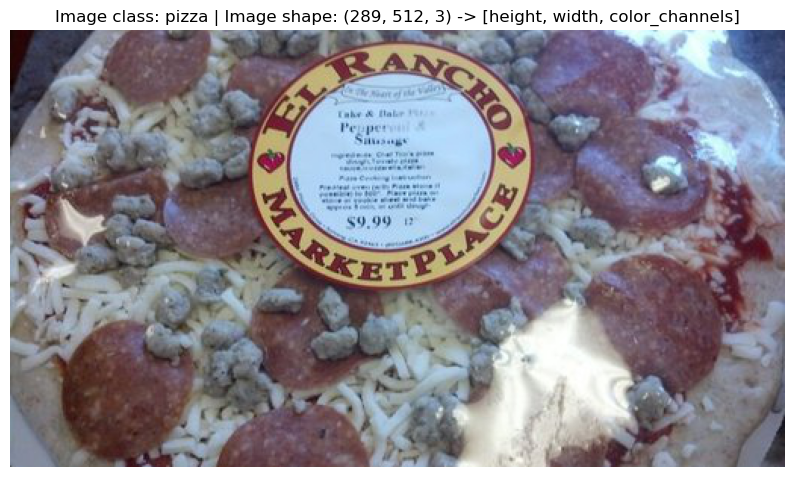

In [42]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)
plt.show()


Now we need to make images compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [43]:
# Transforming data with torchvision.transforms
import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [44]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

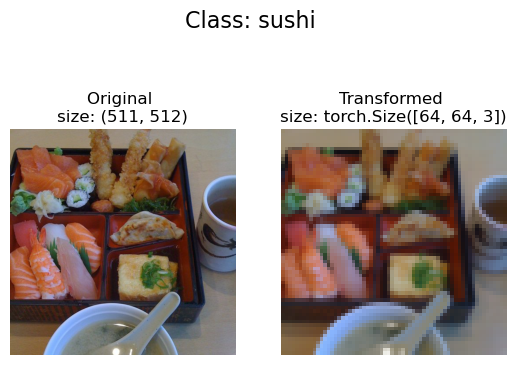

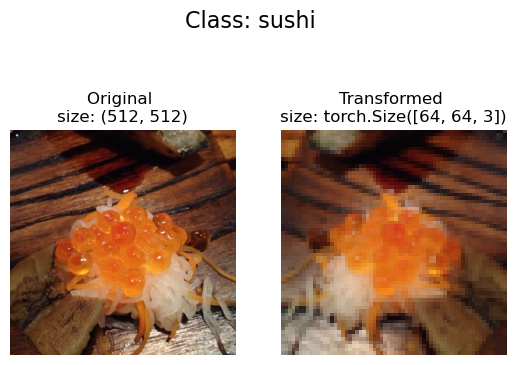

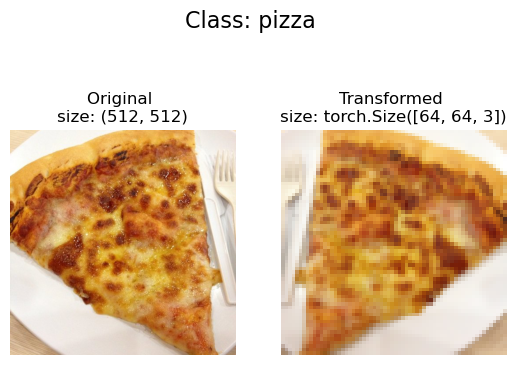

In [45]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths."""
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nsize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)


### Load image data using `ImageFolder`

In [46]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [47]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [48]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [49]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [50]:
# Turn train and test Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7f3b28a06500>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3b28a06ef0>)

In [51]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

In [52]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [53]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(13)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0



TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [54]:
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[-0.0746, -0.0778,  0.0220]], grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [55]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [56]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [57]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

/home/andrey/anaconda3/envs/Ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [58]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

 20%|██        | 1/5 [00:01<00:06,  1.60s/it]

Epoch: 1 | train_loss: 1.1178 | train_acc: 0.2889 | test_loss: 1.0972 | test_acc: 0.4133


 40%|████      | 2/5 [00:03<00:04,  1.58s/it]

Epoch: 2 | train_loss: 1.0998 | train_acc: 0.2844 | test_loss: 1.0991 | test_acc: 0.2533


 60%|██████    | 3/5 [00:04<00:03,  1.56s/it]

Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3156 | test_loss: 1.0993 | test_acc: 0.3333


 80%|████████  | 4/5 [00:06<00:01,  1.53s/it]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3422 | test_loss: 1.0997 | test_acc: 0.3333


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]

Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3244 | test_loss: 1.0994 | test_acc: 0.3333


In [59]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  5%|▌         | 1/20 [00:01<00:30,  1.63s/it]

Epoch: 1 | train_loss: 1.1178 | train_acc: 0.2889 | test_loss: 1.0972 | test_acc: 0.4133


 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

Epoch: 2 | train_loss: 1.0998 | train_acc: 0.2844 | test_loss: 1.0991 | test_acc: 0.2533


 15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3156 | test_loss: 1.0993 | test_acc: 0.3333


 20%|██        | 4/20 [00:06<00:24,  1.53s/it]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3422 | test_loss: 1.0997 | test_acc: 0.3333


 25%|██▌       | 5/20 [00:07<00:22,  1.53s/it]

Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3244 | test_loss: 1.0994 | test_acc: 0.3333


 30%|███       | 6/20 [00:09<00:22,  1.58s/it]

Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3511 | test_loss: 1.0991 | test_acc: 0.3333


 35%|███▌      | 7/20 [00:11<00:20,  1.61s/it]

Epoch: 7 | train_loss: 1.0630 | train_acc: 0.4800 | test_loss: 1.0858 | test_acc: 0.4267


 40%|████      | 8/20 [00:12<00:19,  1.62s/it]

Epoch: 8 | train_loss: 0.9810 | train_acc: 0.5600 | test_loss: 1.0110 | test_acc: 0.4400


 45%|████▌     | 9/20 [00:14<00:17,  1.58s/it]

Epoch: 9 | train_loss: 0.9215 | train_acc: 0.5733 | test_loss: 0.9740 | test_acc: 0.4800


 50%|█████     | 10/20 [00:15<00:15,  1.57s/it]

Epoch: 10 | train_loss: 0.8568 | train_acc: 0.5956 | test_loss: 0.9826 | test_acc: 0.4800


 55%|█████▌    | 11/20 [00:17<00:14,  1.56s/it]

Epoch: 11 | train_loss: 0.8249 | train_acc: 0.6267 | test_loss: 1.0129 | test_acc: 0.4533


 60%|██████    | 12/20 [00:18<00:12,  1.56s/it]

Epoch: 12 | train_loss: 0.7800 | train_acc: 0.6622 | test_loss: 0.9933 | test_acc: 0.4400


 65%|██████▌   | 13/20 [00:20<00:10,  1.52s/it]

Epoch: 13 | train_loss: 0.7389 | train_acc: 0.6978 | test_loss: 0.9996 | test_acc: 0.4400


 70%|███████   | 14/20 [00:21<00:09,  1.50s/it]

Epoch: 14 | train_loss: 0.6685 | train_acc: 0.7111 | test_loss: 1.1227 | test_acc: 0.4933


 75%|███████▌  | 15/20 [00:23<00:07,  1.51s/it]

Epoch: 15 | train_loss: 0.6276 | train_acc: 0.7511 | test_loss: 1.0270 | test_acc: 0.4800


 80%|████████  | 16/20 [00:24<00:06,  1.52s/it]

Epoch: 16 | train_loss: 0.5585 | train_acc: 0.7956 | test_loss: 1.1580 | test_acc: 0.5333


 85%|████████▌ | 17/20 [00:26<00:04,  1.50s/it]

Epoch: 17 | train_loss: 0.4278 | train_acc: 0.8400 | test_loss: 1.4893 | test_acc: 0.4933


 90%|█████████ | 18/20 [00:27<00:03,  1.53s/it]

Epoch: 18 | train_loss: 0.4532 | train_acc: 0.8222 | test_loss: 1.3463 | test_acc: 0.4800


 95%|█████████▌| 19/20 [00:29<00:01,  1.51s/it]

Epoch: 19 | train_loss: 0.3570 | train_acc: 0.8667 | test_loss: 1.7964 | test_acc: 0.4533


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Epoch: 20 | train_loss: 0.4041 | train_acc: 0.8444 | test_loss: 1.5629 | test_acc: 0.5067


In [60]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  2%|▏         | 1/50 [00:01<01:25,  1.75s/it]

Epoch: 1 | train_loss: 1.1178 | train_acc: 0.2889 | test_loss: 1.0972 | test_acc: 0.4133


  4%|▍         | 2/50 [00:03<01:20,  1.67s/it]

Epoch: 2 | train_loss: 1.0998 | train_acc: 0.2844 | test_loss: 1.0991 | test_acc: 0.2533


  6%|▌         | 3/50 [00:04<01:14,  1.58s/it]

Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3156 | test_loss: 1.0993 | test_acc: 0.3333


  8%|▊         | 4/50 [00:06<01:11,  1.56s/it]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3422 | test_loss: 1.0997 | test_acc: 0.3333


 10%|█         | 5/50 [00:07<01:10,  1.56s/it]

Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3244 | test_loss: 1.0994 | test_acc: 0.3333


 12%|█▏        | 6/50 [00:09<01:10,  1.60s/it]

Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3511 | test_loss: 1.0991 | test_acc: 0.3333


 14%|█▍        | 7/50 [00:11<01:09,  1.62s/it]

Epoch: 7 | train_loss: 1.0630 | train_acc: 0.4800 | test_loss: 1.0858 | test_acc: 0.4267


 16%|█▌        | 8/50 [00:12<01:08,  1.64s/it]

Epoch: 8 | train_loss: 0.9810 | train_acc: 0.5600 | test_loss: 1.0110 | test_acc: 0.4400


 18%|█▊        | 9/50 [00:14<01:08,  1.67s/it]

Epoch: 9 | train_loss: 0.9215 | train_acc: 0.5733 | test_loss: 0.9740 | test_acc: 0.4800


 20%|██        | 10/50 [00:16<01:03,  1.59s/it]

Epoch: 10 | train_loss: 0.8568 | train_acc: 0.5956 | test_loss: 0.9826 | test_acc: 0.4800


 22%|██▏       | 11/50 [00:17<00:59,  1.53s/it]

Epoch: 11 | train_loss: 0.8249 | train_acc: 0.6267 | test_loss: 1.0129 | test_acc: 0.4533


 24%|██▍       | 12/50 [00:18<00:57,  1.50s/it]

Epoch: 12 | train_loss: 0.7800 | train_acc: 0.6622 | test_loss: 0.9933 | test_acc: 0.4400


 26%|██▌       | 13/50 [00:20<00:54,  1.48s/it]

Epoch: 13 | train_loss: 0.7389 | train_acc: 0.6978 | test_loss: 0.9996 | test_acc: 0.4400


 28%|██▊       | 14/50 [00:21<00:52,  1.46s/it]

Epoch: 14 | train_loss: 0.6685 | train_acc: 0.7111 | test_loss: 1.1227 | test_acc: 0.4933


 30%|███       | 15/50 [00:23<00:50,  1.43s/it]

Epoch: 15 | train_loss: 0.6276 | train_acc: 0.7511 | test_loss: 1.0270 | test_acc: 0.4800


 32%|███▏      | 16/50 [00:24<00:48,  1.43s/it]

Epoch: 16 | train_loss: 0.5585 | train_acc: 0.7956 | test_loss: 1.1580 | test_acc: 0.5333


 34%|███▍      | 17/50 [00:25<00:46,  1.42s/it]

Epoch: 17 | train_loss: 0.4278 | train_acc: 0.8400 | test_loss: 1.4893 | test_acc: 0.4933


 36%|███▌      | 18/50 [00:27<00:45,  1.42s/it]

Epoch: 18 | train_loss: 0.4532 | train_acc: 0.8222 | test_loss: 1.3463 | test_acc: 0.4800


 38%|███▊      | 19/50 [00:28<00:43,  1.41s/it]

Epoch: 19 | train_loss: 0.3570 | train_acc: 0.8667 | test_loss: 1.7964 | test_acc: 0.4533


 40%|████      | 20/50 [00:30<00:42,  1.42s/it]

Epoch: 20 | train_loss: 0.4041 | train_acc: 0.8444 | test_loss: 1.5629 | test_acc: 0.5067


 42%|████▏     | 21/50 [00:31<00:42,  1.47s/it]

Epoch: 21 | train_loss: 0.3292 | train_acc: 0.8667 | test_loss: 2.0104 | test_acc: 0.5600


 44%|████▍     | 22/50 [00:33<00:41,  1.49s/it]

Epoch: 22 | train_loss: 0.2207 | train_acc: 0.9289 | test_loss: 2.0005 | test_acc: 0.4000


 46%|████▌     | 23/50 [00:34<00:40,  1.49s/it]

Epoch: 23 | train_loss: 0.1772 | train_acc: 0.9378 | test_loss: 1.8221 | test_acc: 0.4667


 48%|████▊     | 24/50 [00:36<00:38,  1.47s/it]

Epoch: 24 | train_loss: 0.2326 | train_acc: 0.9067 | test_loss: 2.2280 | test_acc: 0.4667


 50%|█████     | 25/50 [00:37<00:36,  1.47s/it]

Epoch: 25 | train_loss: 0.1404 | train_acc: 0.9556 | test_loss: 2.5073 | test_acc: 0.5067


 52%|█████▏    | 26/50 [00:39<00:34,  1.44s/it]

Epoch: 26 | train_loss: 0.0861 | train_acc: 0.9733 | test_loss: 2.7370 | test_acc: 0.5333


 54%|█████▍    | 27/50 [00:40<00:32,  1.43s/it]

Epoch: 27 | train_loss: 0.1103 | train_acc: 0.9467 | test_loss: 3.0267 | test_acc: 0.4933


 56%|█████▌    | 28/50 [00:41<00:31,  1.43s/it]

Epoch: 28 | train_loss: 0.1445 | train_acc: 0.9511 | test_loss: 3.3976 | test_acc: 0.4667


 58%|█████▊    | 29/50 [00:43<00:30,  1.43s/it]

Epoch: 29 | train_loss: 0.0789 | train_acc: 0.9689 | test_loss: 4.2452 | test_acc: 0.4933


 60%|██████    | 30/50 [00:44<00:28,  1.42s/it]

Epoch: 30 | train_loss: 0.0758 | train_acc: 0.9733 | test_loss: 2.8750 | test_acc: 0.4267


 62%|██████▏   | 31/50 [00:46<00:27,  1.42s/it]

Epoch: 31 | train_loss: 0.1067 | train_acc: 0.9644 | test_loss: 2.9167 | test_acc: 0.5067


 64%|██████▍   | 32/50 [00:47<00:25,  1.41s/it]

Epoch: 32 | train_loss: 0.0946 | train_acc: 0.9689 | test_loss: 3.4294 | test_acc: 0.4800


 66%|██████▌   | 33/50 [00:49<00:24,  1.43s/it]

Epoch: 33 | train_loss: 0.0608 | train_acc: 0.9689 | test_loss: 3.0136 | test_acc: 0.4933


 68%|██████▊   | 34/50 [00:50<00:22,  1.43s/it]

Epoch: 34 | train_loss: 0.0313 | train_acc: 0.9911 | test_loss: 3.5354 | test_acc: 0.4933


 70%|███████   | 35/50 [00:51<00:21,  1.43s/it]

Epoch: 35 | train_loss: 0.0516 | train_acc: 0.9867 | test_loss: 4.2489 | test_acc: 0.4800


 72%|███████▏  | 36/50 [00:53<00:19,  1.42s/it]

Epoch: 36 | train_loss: 0.0362 | train_acc: 0.9911 | test_loss: 3.8320 | test_acc: 0.5067


 74%|███████▍  | 37/50 [00:54<00:18,  1.42s/it]

Epoch: 37 | train_loss: 0.1492 | train_acc: 0.9600 | test_loss: 5.3819 | test_acc: 0.4933


 76%|███████▌  | 38/50 [00:56<00:16,  1.41s/it]

Epoch: 38 | train_loss: 0.0926 | train_acc: 0.9511 | test_loss: 4.6790 | test_acc: 0.4800


 78%|███████▊  | 39/50 [00:57<00:15,  1.40s/it]

Epoch: 39 | train_loss: 0.0426 | train_acc: 0.9867 | test_loss: 3.9109 | test_acc: 0.5467


 80%|████████  | 40/50 [00:58<00:14,  1.41s/it]

Epoch: 40 | train_loss: 0.0163 | train_acc: 0.9956 | test_loss: 4.8083 | test_acc: 0.5200


 82%|████████▏ | 41/50 [01:00<00:12,  1.41s/it]

Epoch: 41 | train_loss: 0.0121 | train_acc: 1.0000 | test_loss: 4.8700 | test_acc: 0.5333


 84%|████████▍ | 42/50 [01:01<00:11,  1.46s/it]

Epoch: 42 | train_loss: 0.0096 | train_acc: 0.9956 | test_loss: 6.5361 | test_acc: 0.5200


 86%|████████▌ | 43/50 [01:03<00:10,  1.50s/it]

Epoch: 43 | train_loss: 0.0185 | train_acc: 0.9867 | test_loss: 5.9235 | test_acc: 0.4800


 88%|████████▊ | 44/50 [01:04<00:08,  1.48s/it]

Epoch: 44 | train_loss: 0.0090 | train_acc: 1.0000 | test_loss: 5.4685 | test_acc: 0.5200


 90%|█████████ | 45/50 [01:06<00:07,  1.46s/it]

Epoch: 45 | train_loss: 0.0048 | train_acc: 1.0000 | test_loss: 6.1382 | test_acc: 0.5067


 92%|█████████▏| 46/50 [01:07<00:05,  1.46s/it]

Epoch: 46 | train_loss: 0.0038 | train_acc: 1.0000 | test_loss: 5.9030 | test_acc: 0.5333


 94%|█████████▍| 47/50 [01:09<00:04,  1.45s/it]

Epoch: 47 | train_loss: 0.0031 | train_acc: 1.0000 | test_loss: 6.2094 | test_acc: 0.5333


 96%|█████████▌| 48/50 [01:10<00:02,  1.44s/it]

Epoch: 48 | train_loss: 0.0018 | train_acc: 1.0000 | test_loss: 6.5868 | test_acc: 0.5333


 98%|█████████▊| 49/50 [01:12<00:01,  1.44s/it]

Epoch: 49 | train_loss: 0.0025 | train_acc: 1.0000 | test_loss: 6.0244 | test_acc: 0.5867


100%|██████████| 50/50 [01:13<00:00,  1.47s/it]

Epoch: 50 | train_loss: 0.0012 | train_acc: 1.0000 | test_loss: 6.0336 | test_acc: 0.5467


It looks like our model is starting to overfit towards the end.

In order to fix this, we'd have to introduce ways of preventing overfitting or to use less epoches

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [61]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20, # here increase hidden layers
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  5%|▌         | 1/20 [00:01<00:33,  1.76s/it]

Epoch: 1 | train_loss: 1.0880 | train_acc: 0.4222 | test_loss: 1.0260 | test_acc: 0.4933


 10%|█         | 2/20 [00:03<00:31,  1.76s/it]

Epoch: 2 | train_loss: 0.9670 | train_acc: 0.5600 | test_loss: 1.0220 | test_acc: 0.4400


 15%|█▌        | 3/20 [00:05<00:29,  1.76s/it]

Epoch: 3 | train_loss: 0.9252 | train_acc: 0.5733 | test_loss: 0.9533 | test_acc: 0.4933


 20%|██        | 4/20 [00:07<00:28,  1.75s/it]

Epoch: 4 | train_loss: 0.8685 | train_acc: 0.6000 | test_loss: 0.9720 | test_acc: 0.4933


 25%|██▌       | 5/20 [00:08<00:26,  1.75s/it]

Epoch: 5 | train_loss: 0.8689 | train_acc: 0.6000 | test_loss: 0.9999 | test_acc: 0.4267


 30%|███       | 6/20 [00:10<00:24,  1.72s/it]

Epoch: 6 | train_loss: 0.8270 | train_acc: 0.6267 | test_loss: 0.9718 | test_acc: 0.4267


 35%|███▌      | 7/20 [00:12<00:22,  1.69s/it]

Epoch: 7 | train_loss: 0.7743 | train_acc: 0.6667 | test_loss: 1.0590 | test_acc: 0.4667


 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

Epoch: 8 | train_loss: 0.7205 | train_acc: 0.7022 | test_loss: 1.0765 | test_acc: 0.5067


 45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

Epoch: 9 | train_loss: 0.6989 | train_acc: 0.6889 | test_loss: 1.1332 | test_acc: 0.5067


 50%|█████     | 10/20 [00:17<00:16,  1.69s/it]

Epoch: 10 | train_loss: 0.6402 | train_acc: 0.7378 | test_loss: 1.1911 | test_acc: 0.5867


 55%|█████▌    | 11/20 [00:19<00:15,  1.75s/it]

Epoch: 11 | train_loss: 0.5546 | train_acc: 0.7867 | test_loss: 1.2480 | test_acc: 0.5333


 60%|██████    | 12/20 [00:20<00:14,  1.78s/it]

Epoch: 12 | train_loss: 0.6050 | train_acc: 0.8044 | test_loss: 1.5660 | test_acc: 0.4400


 65%|██████▌   | 13/20 [00:22<00:12,  1.76s/it]

Epoch: 13 | train_loss: 0.5754 | train_acc: 0.8044 | test_loss: 1.3947 | test_acc: 0.4400


 70%|███████   | 14/20 [00:24<00:10,  1.77s/it]

Epoch: 14 | train_loss: 0.4880 | train_acc: 0.7778 | test_loss: 1.3601 | test_acc: 0.4800


 75%|███████▌  | 15/20 [00:26<00:08,  1.77s/it]

Epoch: 15 | train_loss: 0.4144 | train_acc: 0.8178 | test_loss: 1.7490 | test_acc: 0.4533


 80%|████████  | 16/20 [00:27<00:06,  1.75s/it]

Epoch: 16 | train_loss: 0.4139 | train_acc: 0.8489 | test_loss: 2.0890 | test_acc: 0.4667


 85%|████████▌ | 17/20 [00:29<00:05,  1.72s/it]

Epoch: 17 | train_loss: 0.3453 | train_acc: 0.8444 | test_loss: 2.3395 | test_acc: 0.4667


 90%|█████████ | 18/20 [00:31<00:03,  1.73s/it]

Epoch: 18 | train_loss: 0.3443 | train_acc: 0.8800 | test_loss: 2.5080 | test_acc: 0.4933


 95%|█████████▌| 19/20 [00:32<00:01,  1.71s/it]

Epoch: 19 | train_loss: 0.3208 | train_acc: 0.8800 | test_loss: 1.7604 | test_acc: 0.4533


100%|██████████| 20/20 [00:34<00:00,  1.73s/it]

Epoch: 20 | train_loss: 0.2700 | train_acc: 0.9022 | test_loss: 2.4204 | test_acc: 0.4400


It looks like the model is still overfitting, even when changing the number of hidden units.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [62]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [63]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.


Now have double the training and testing images.

In [64]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [65]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [66]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent, # use double the training data
                        test_dataloader=test_dataloader_20_percent, # use double the testing data
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

Epoch: 1 | train_loss: 1.1044 | train_acc: 0.3333 | test_loss: 1.1013 | test_acc: 0.2875


 10%|█         | 2/20 [00:02<00:25,  1.43s/it]

Epoch: 2 | train_loss: 1.0896 | train_acc: 0.3521 | test_loss: 1.0826 | test_acc: 0.3244


 15%|█▌        | 3/20 [00:04<00:24,  1.45s/it]

Epoch: 3 | train_loss: 1.0480 | train_acc: 0.4229 | test_loss: 1.0074 | test_acc: 0.3807


 20%|██        | 4/20 [00:05<00:23,  1.46s/it]

Epoch: 4 | train_loss: 0.9251 | train_acc: 0.5854 | test_loss: 0.9177 | test_acc: 0.5523


 25%|██▌       | 5/20 [00:07<00:21,  1.46s/it]

Epoch: 5 | train_loss: 0.8763 | train_acc: 0.5813 | test_loss: 0.9261 | test_acc: 0.5176


 30%|███       | 6/20 [00:08<00:20,  1.49s/it]

Epoch: 6 | train_loss: 0.8210 | train_acc: 0.6583 | test_loss: 1.0265 | test_acc: 0.4744


 35%|███▌      | 7/20 [00:10<00:19,  1.52s/it]

Epoch: 7 | train_loss: 0.8801 | train_acc: 0.6021 | test_loss: 0.8711 | test_acc: 0.5722


 40%|████      | 8/20 [00:11<00:18,  1.53s/it]

Epoch: 8 | train_loss: 0.7684 | train_acc: 0.6625 | test_loss: 0.8615 | test_acc: 0.6381


 45%|████▌     | 9/20 [00:13<00:16,  1.52s/it]

Epoch: 9 | train_loss: 0.7569 | train_acc: 0.6875 | test_loss: 0.9014 | test_acc: 0.5773


 50%|█████     | 10/20 [00:14<00:14,  1.49s/it]

Epoch: 10 | train_loss: 0.7596 | train_acc: 0.6792 | test_loss: 0.8797 | test_acc: 0.6347


 55%|█████▌    | 11/20 [00:16<00:13,  1.46s/it]

Epoch: 11 | train_loss: 0.7019 | train_acc: 0.6958 | test_loss: 0.9009 | test_acc: 0.6568


 60%|██████    | 12/20 [00:17<00:11,  1.46s/it]

Epoch: 12 | train_loss: 0.6538 | train_acc: 0.7104 | test_loss: 0.9230 | test_acc: 0.6136


 65%|██████▌   | 13/20 [00:19<00:10,  1.45s/it]

Epoch: 13 | train_loss: 0.5945 | train_acc: 0.7562 | test_loss: 0.9243 | test_acc: 0.5881


 70%|███████   | 14/20 [00:20<00:08,  1.46s/it]

Epoch: 14 | train_loss: 0.5194 | train_acc: 0.7937 | test_loss: 1.0598 | test_acc: 0.5761


 75%|███████▌  | 15/20 [00:22<00:07,  1.46s/it]

Epoch: 15 | train_loss: 0.4606 | train_acc: 0.8417 | test_loss: 1.1086 | test_acc: 0.5761


 80%|████████  | 16/20 [00:23<00:05,  1.46s/it]

Epoch: 16 | train_loss: 0.4864 | train_acc: 0.7979 | test_loss: 1.0737 | test_acc: 0.5977


 85%|████████▌ | 17/20 [00:25<00:04,  1.47s/it]

Epoch: 17 | train_loss: 0.4883 | train_acc: 0.7646 | test_loss: 1.0671 | test_acc: 0.5511


 90%|█████████ | 18/20 [00:26<00:02,  1.49s/it]

Epoch: 18 | train_loss: 0.3772 | train_acc: 0.8479 | test_loss: 1.3520 | test_acc: 0.5364


 95%|█████████▌| 19/20 [00:28<00:01,  1.48s/it]

Epoch: 19 | train_loss: 0.3942 | train_acc: 0.8521 | test_loss: 1.1775 | test_acc: 0.5710


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]

Epoch: 20 | train_loss: 0.3455 | train_acc: 0.8771 | test_loss: 1.2847 | test_acc: 0.5506


But model is still getting overfit.

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.


In [78]:

import requests
from PIL import Image

# URL of the image
#custom_image_url = "https://bogatyr.club/uploads/posts/2023-03/thumbs/1678391075_bogatyr-club-p-originalnaya-italyanskaya-pitstsa-foni-pin-43.jpg"
#custom_image_url = "https://cobrio.club/uploads/posts/2022-10/1666011318_16-cobrio-club-p-sushi-na-stole-doma-dizain-pinterest-16.jpg"
custom_image_url = "https://mig.pics/x/uploads/posts/2023-12/1703204386_mykaleidoscope-ru-p-malaya-pitstsa-krasivo-50.jpg"
custom_image_path = "custom.jpeg"

# Download the image
response = requests.get(custom_image_url)
with open(custom_image_path, "wb") as f:
    f.write(response.content)

img = Image.open(custom_image_path)
response


<Response [200]>

There are 3 custom images, uncomment to switch

In [79]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image_path)
print(f"Image shape: {img.shape}")


Image shape: torch.Size([3, 854, 1280])


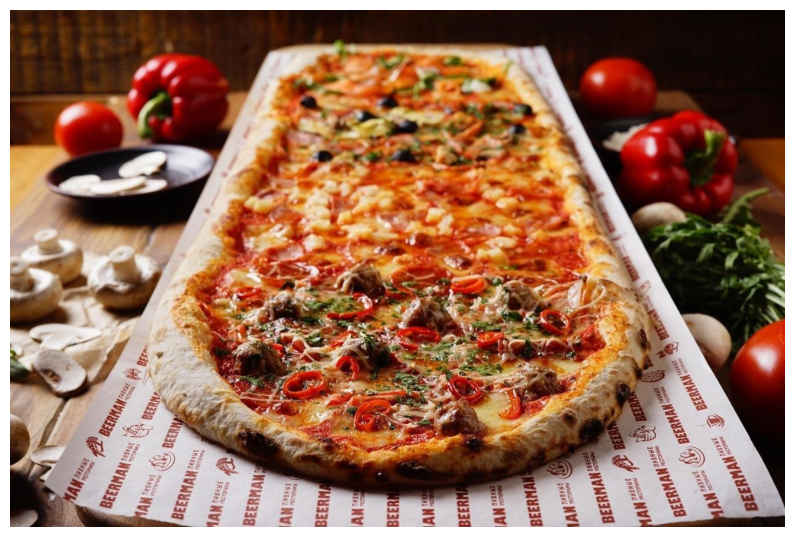

In [80]:
# Show the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False);

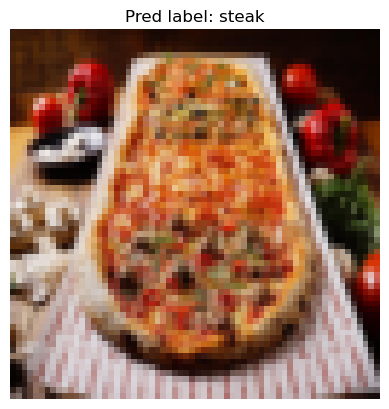

In [81]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  img = img / 255.
  resize = transforms.Resize((64, 64))
  img = resize(img)

  batch = img.unsqueeze(0).to(device)

  y_pred_logit = model_4(batch)

  pred_label = torch.argmax(y_pred_logit, dim=1)

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);

As we can see, accuracu on real images is low, two custom images were detected wrong